<a href="https://colab.research.google.com/github/Suhaib-AbuRaidah/Intro2ML_Assignments/blob/main/Assignment1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Five Ideas to use a smartphone's sensors to analyze data

**First idea:** Capture an image of a checkerboard and detect its corners using either OpenCV’s built-in corner detectors or a Harris corner detector implemented with NumPy. Then, apply the corner detection method to multiple views of the same checkerboard to obtain the corner coordinates, which can be used to estimate the calibration matrix of the phone camera (the matrix that defines the camera’s intrinsic parameters such as focal length and optical center).

**Second idea:** Record a person speaking outdoors in a windy environment and
apply a high-pass filter to reduce wind noise.

**Third idea:** Capture multiple images of an object from different viewpoints
and identify corresponding points in the images using ORB or SIFT feature
extractors (non-AI based).

**Fourth idea:** Record accelerometer data while moving, integrate and
double-integrate the signals to estimate velocity and distance traveled,
and then apply a PID controller or a Kalman filter for motion tracking.

**Fifth idea:** Measure ambient light sensor (ALS) readings outdoors during
daylight and compare them with reference clear-sky radiance data for the same
time, date, and location to estimate cloudiness. (how cloudy the weather is).

# Implementing the First Idea

The cell below is for importing necessary packages

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

This cell is to clone the Github repo containing the image of the checkerboard taken by my phone.

In [2]:
!git clone https://github.com/Suhaib-AbuRaidah/Intro2ML_Assignments.git


Cloning into 'Intro2ML_Assignments'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 68 (delta 13), reused 20 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 5.03 MiB | 1.53 MiB/s, done.
Resolving deltas: 100% (13/13), done.


Here we load and display the image of the checkerboard.

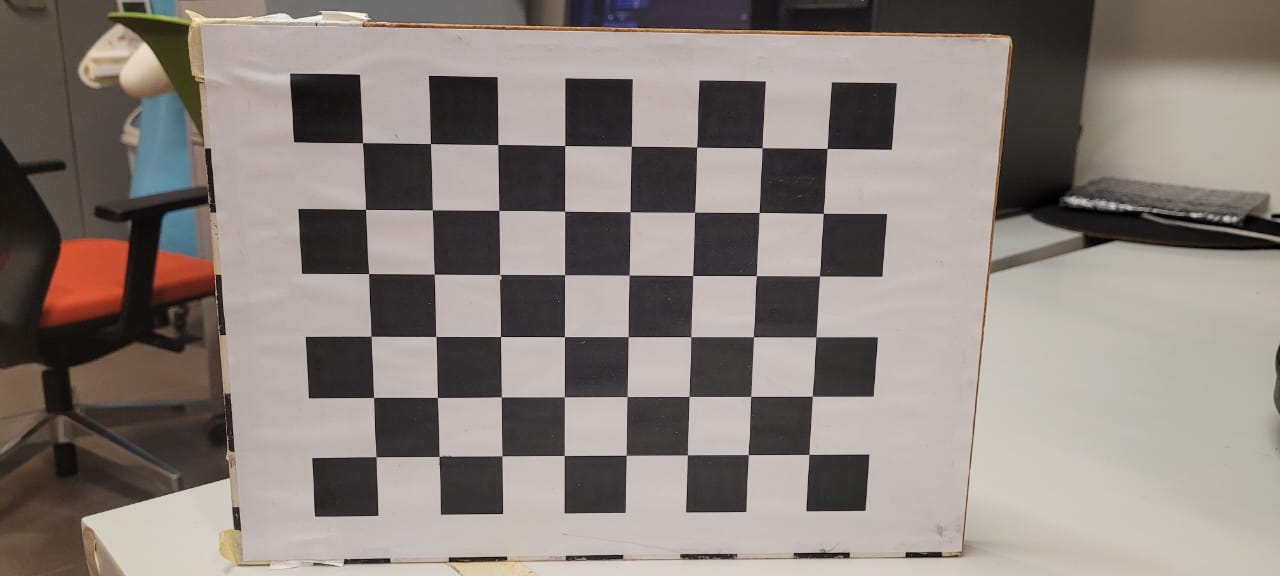

In [3]:
img = cv2.imread("Intro2ML_Assignments/Assignment1/Checkerboard.jpeg")
cv2_imshow(img)

This cell below is for cropping the background from the image and displaying the cropped image.

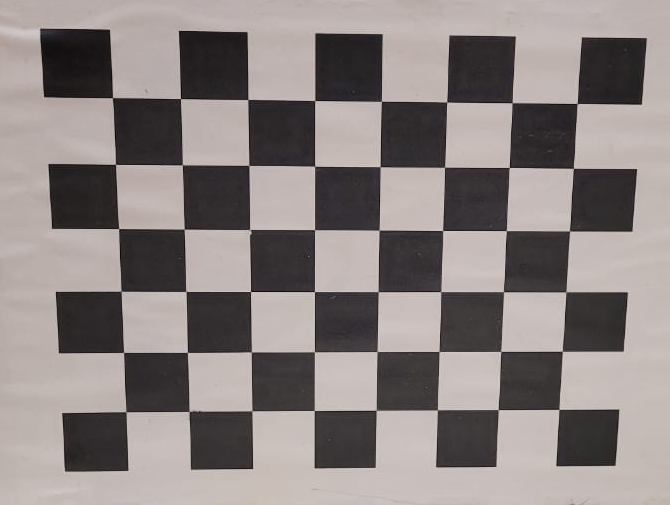

In [4]:
img = img[45:550,250:920]
cv2_imshow(img)

In this cell we define the function that does the convolution over the image, necssary for applying the differntiating filter.

In [5]:
def convolve(image, kernel):
    H, W = image.shape
    kH, kW = kernel.shape
    offsetH = kH // 2 # equals 1 for a kernel of shape (3,3), it means that the first and last line will be skipped in the x-dimension.
    offsetW = kW // 2 # The same here, but for the y-dimension.

    output = np.zeros_like(image)
    # looping in the pixels to convolve with the Sobel kernel.
    for i in range(offsetH, H - offsetH):
        for j in range(offsetW, W - offsetW):
            region = image[i - offsetH:i + offsetH + 1, j - offsetW:j + offsetW + 1] # choosing part of the image (3,3) to covolve.
            output[i, j] = np.sum(region * kernel) # pixel-wise multiplication with the kernel and summing the result for each pixel.

    return output

No we define the Harris corner detector algorithm function, this algorithm is done from scratch using only numpy.

In [6]:
def harris_corner_detection(image, k=0.04, window_size=3):
    # Load and convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)

    # Define Sobel kernels in x and y dimensions to find the gradient.
    sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float64)

    sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]], dtype=np.float64)

    # Compute image gradients using convolve function with Sobel kernels
    Ix = convolve(gray, sobel_x)
    Iy = convolve(gray, sobel_y)

    # Compute products of derivatives
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Define window size
    kernel = np.ones((window_size, window_size))

    # Convolve with window of ones.
    Sxx = convolve(Ixx, kernel)
    Syy = convolve(Iyy, kernel)
    Sxy = convolve(Ixy, kernel)

    # Compute Harris response
    detM = (Sxx * Syy)-(Sxy ** 2)
    traceM = Sxx + Syy
    R = detM - k * ((traceM/2) ** 2) # R is the Harris response of the image
    image[R>0.01*R.max()]= [0,0,255] # Find the corners by comparing Harris response to a threshold of [0.01*R.max()]
    # Show the image
    cv2_imshow(image)

    return image

The cell below is for defining the function to use the built-in Open-CV Harris corner detector function. It is used as a baseline for the algorithm in the cell above.

In [7]:
def built_in_harris(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.1)
    dst = cv2.dilate(dst, None)
    image[dst > 0.01*dst.max()] = [0, 0, 255]
    cv2_imshow(image)

In this cell the built-in Harris corner detector in the Open-CV library is applied on the image. (The red dots are clearly the corners)

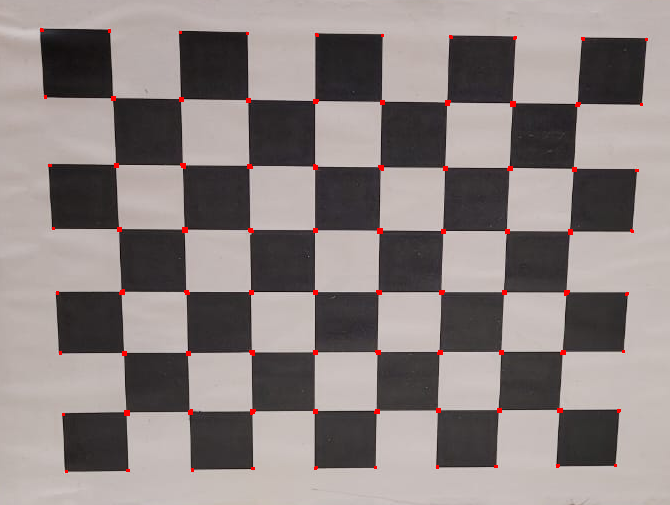

In [8]:
img_built_in = np.copy(img)
built_in_harris(img_built_in)

The below cell is for applying the Harris detector algorithm implemented using numpy on the image.

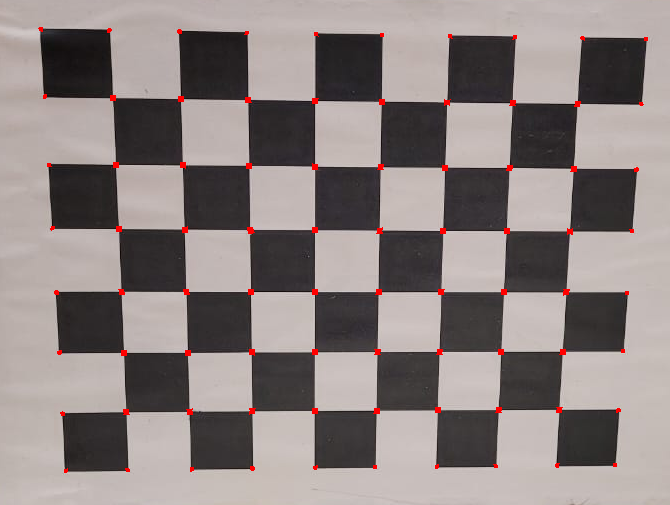

In [9]:
img_manual = np.copy(img)
corners = harris_corner_detection(img_manual, k=0.4, window_size=5) # takes 15 seconds

After implementing and testing the Harris corner detector, we can extend the same approach to detect corners in multiple views of a checkerboard. The corner coordinates from each image can then be saved and later used with OpenCV’s built-in function cv2.calibrateCamera to estimate the phone’s camera calibration matrix.

The code in the following cell loads the multi-view images captured by the phone, converts them to grayscale, detects the corners, and displays each image with the detected corners. Finally, it saves the corner coordinates for later use.

Image:1 with corners detected and saved in 'Corners_List.npy'


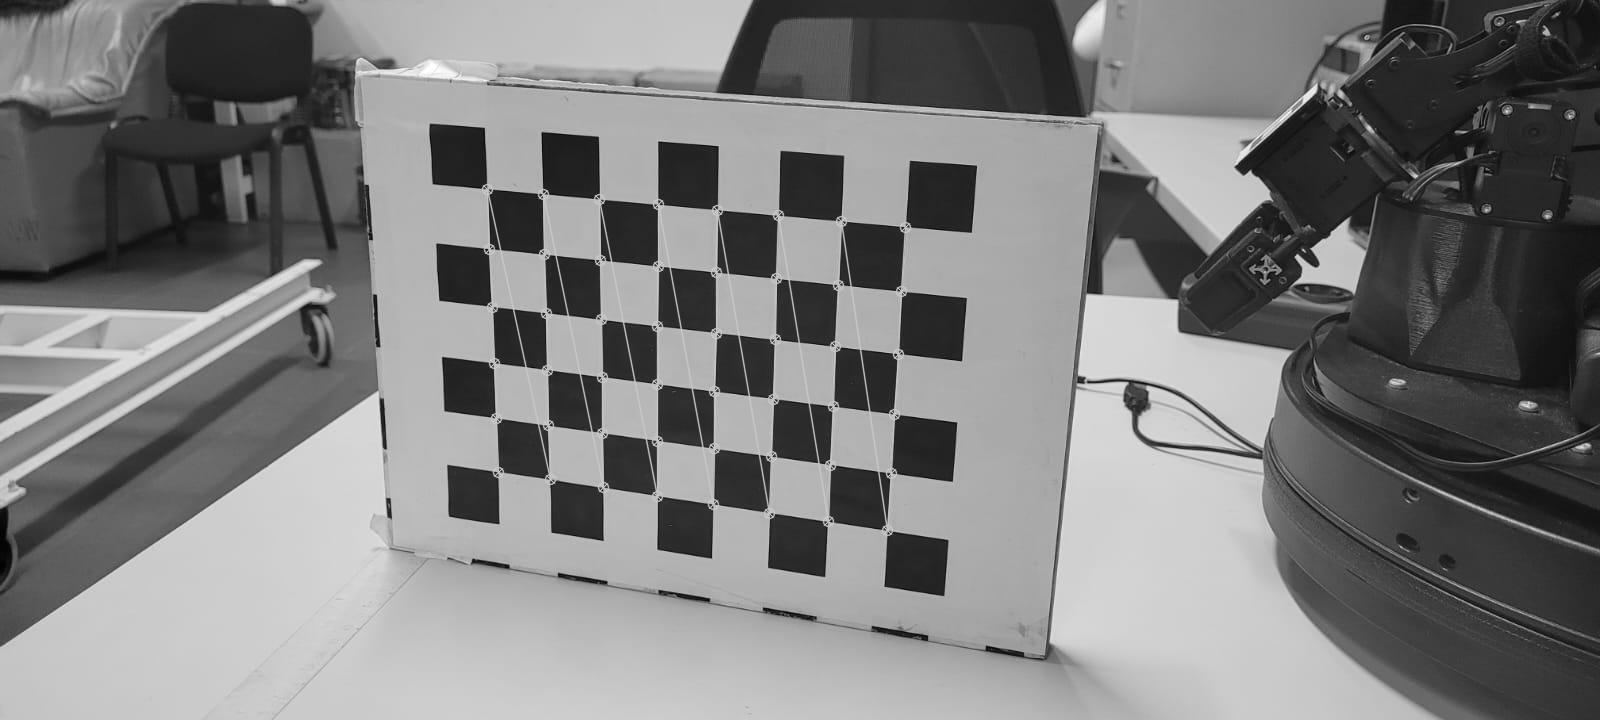

Image:2 with corners detected and saved in 'Corners_List.npy'


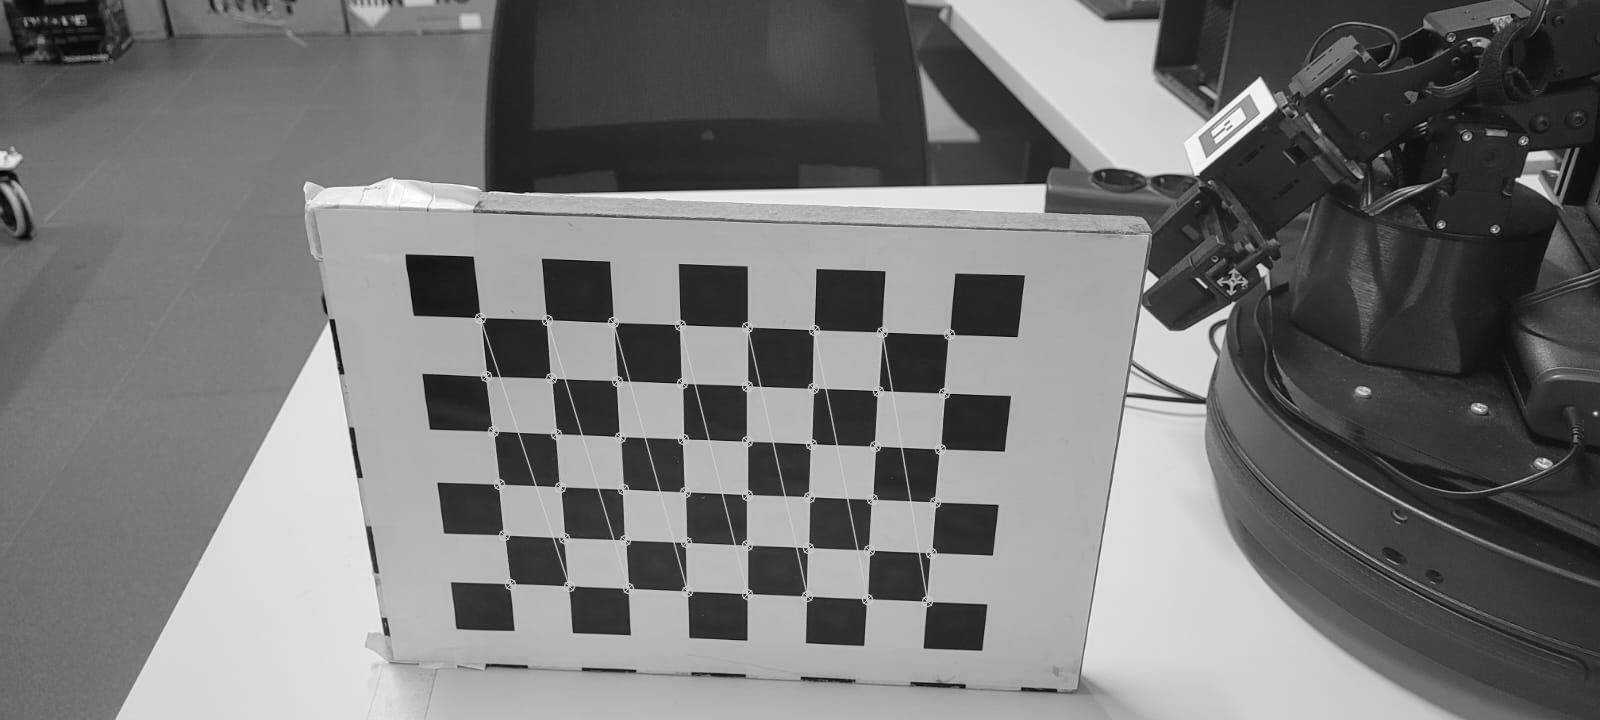

Image:3 with corners detected and saved in 'Corners_List.npy'


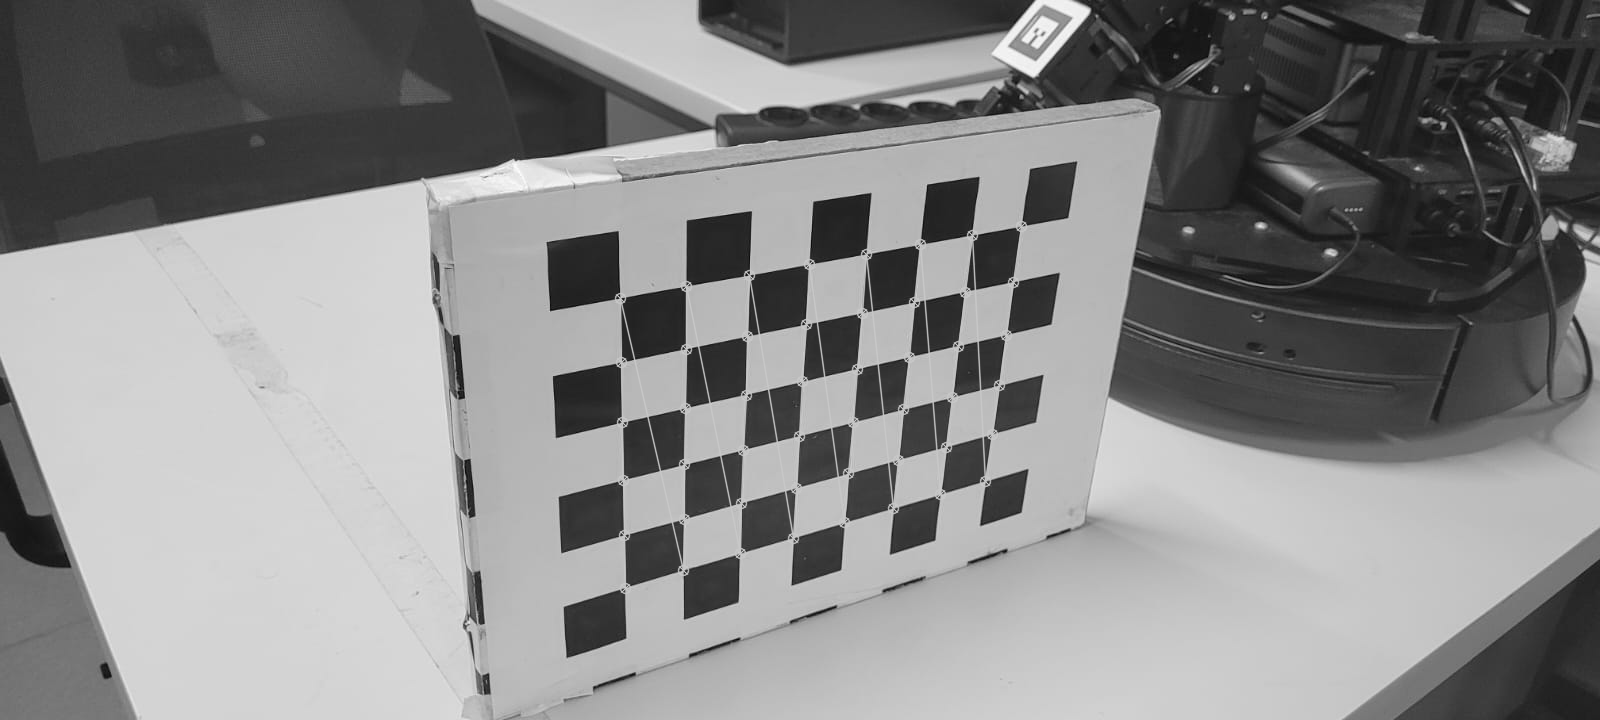

Image:4 with corners detected and saved in 'Corners_List.npy'


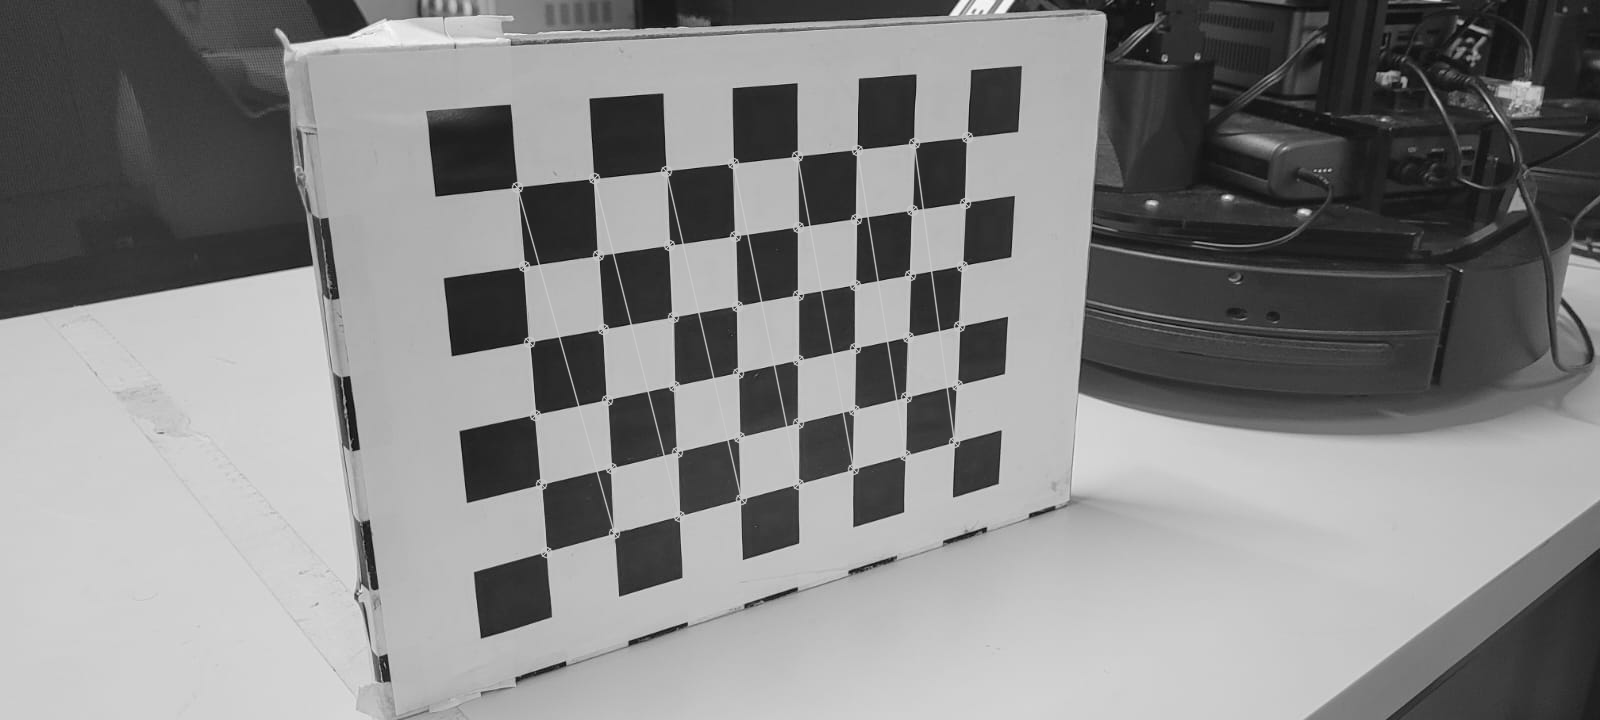

Image:5 with corners detected and saved in 'Corners_List.npy'


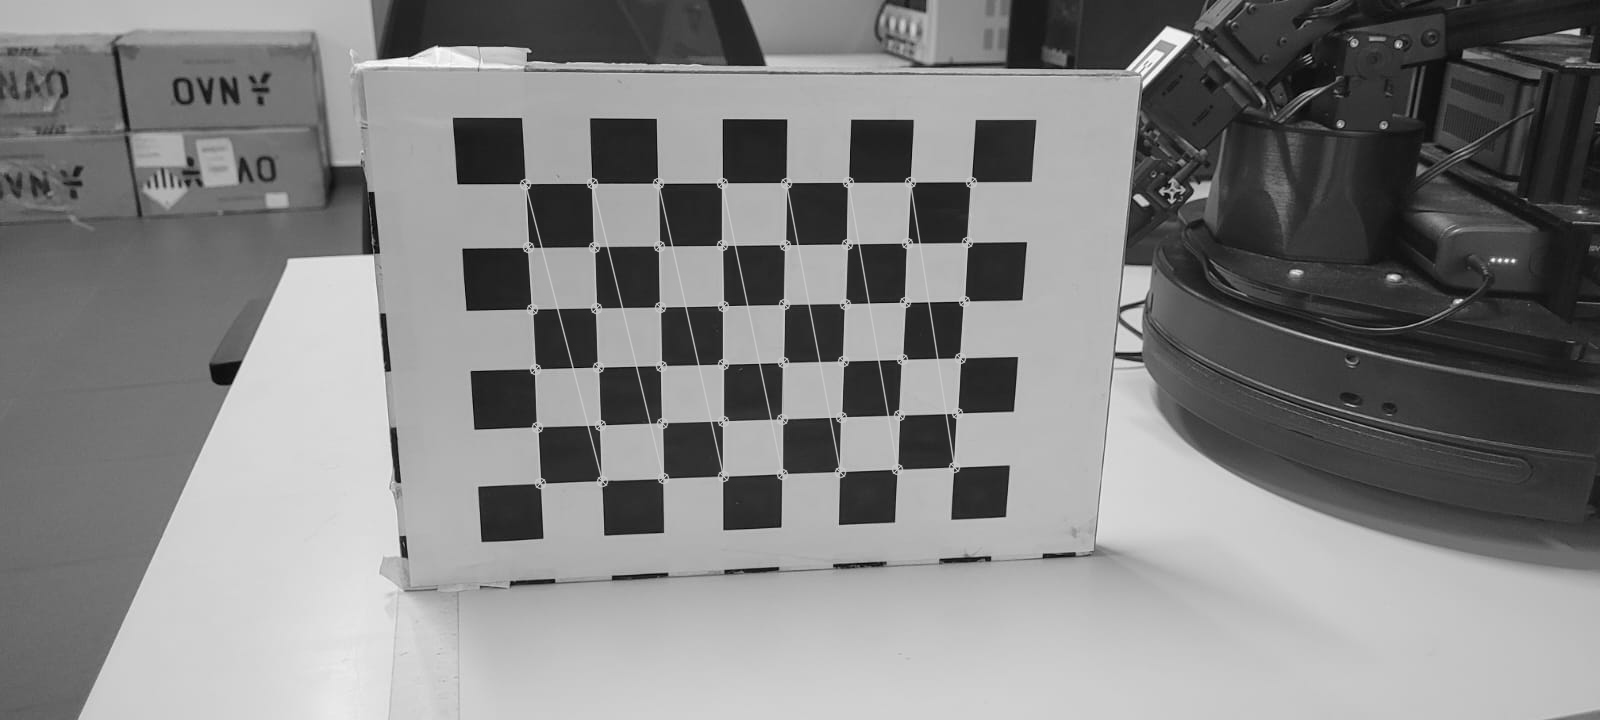

Image:6 with corners detected and saved in 'Corners_List.npy'


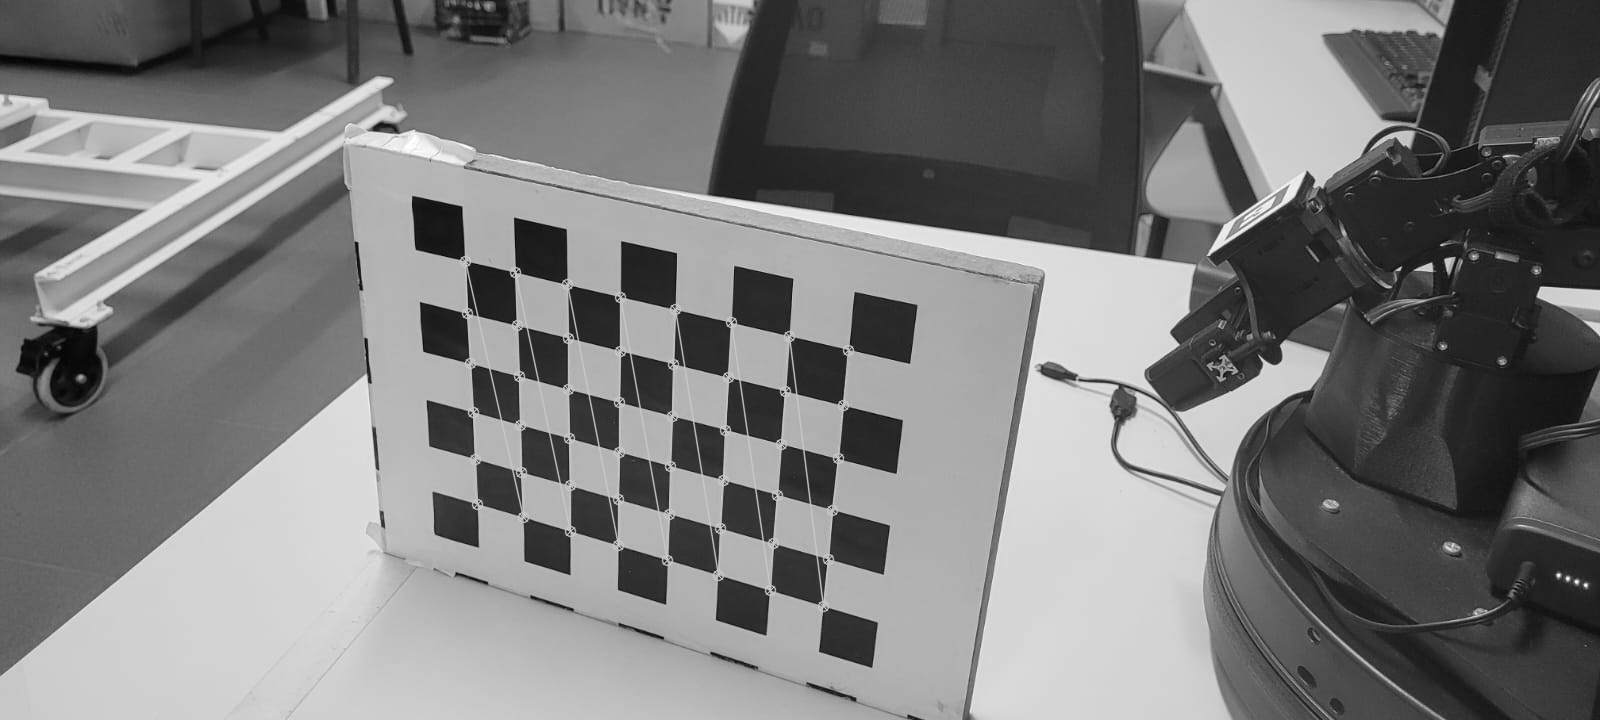

Image:7 with corners detected and saved in 'Corners_List.npy'


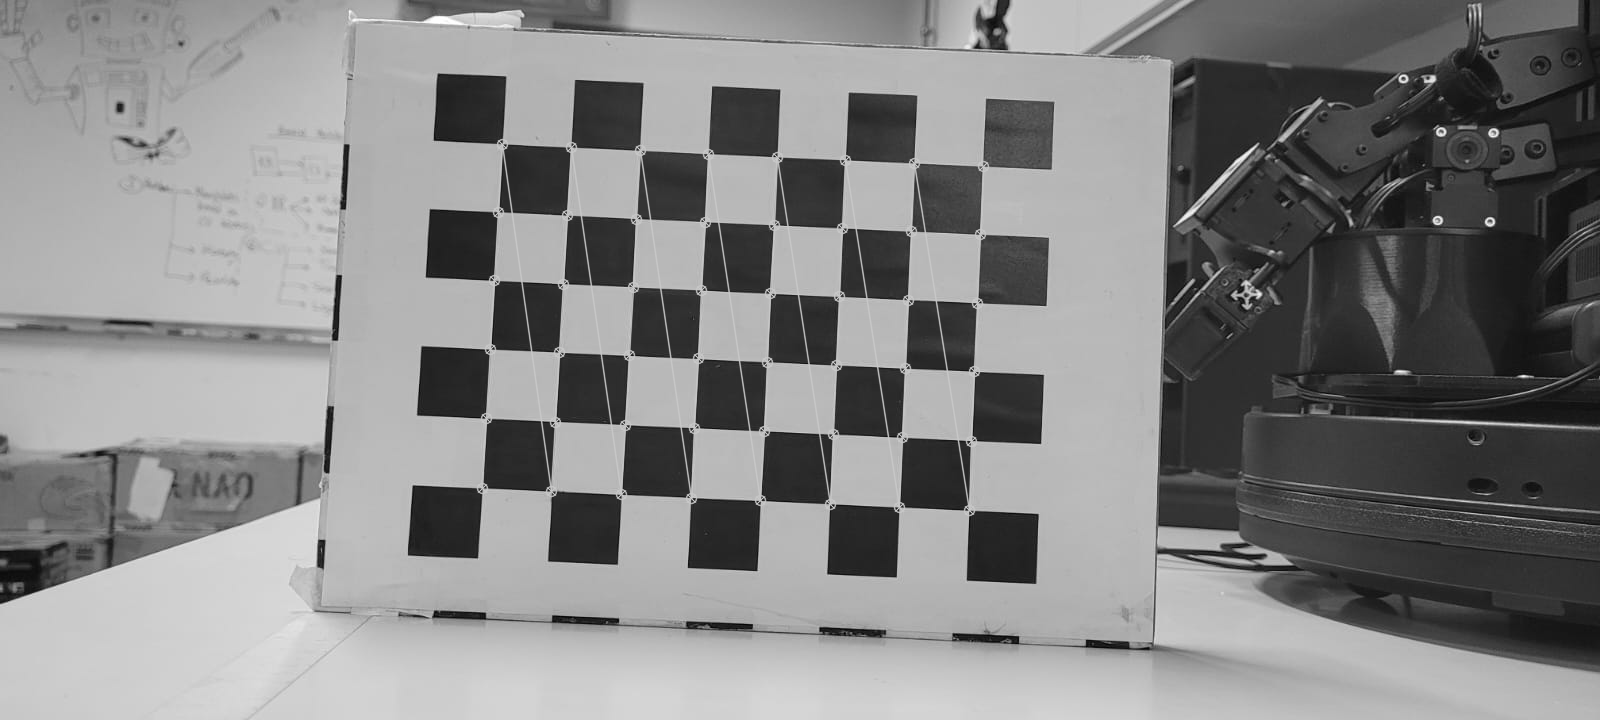

Image:8 with corners detected and saved in 'Corners_List.npy'


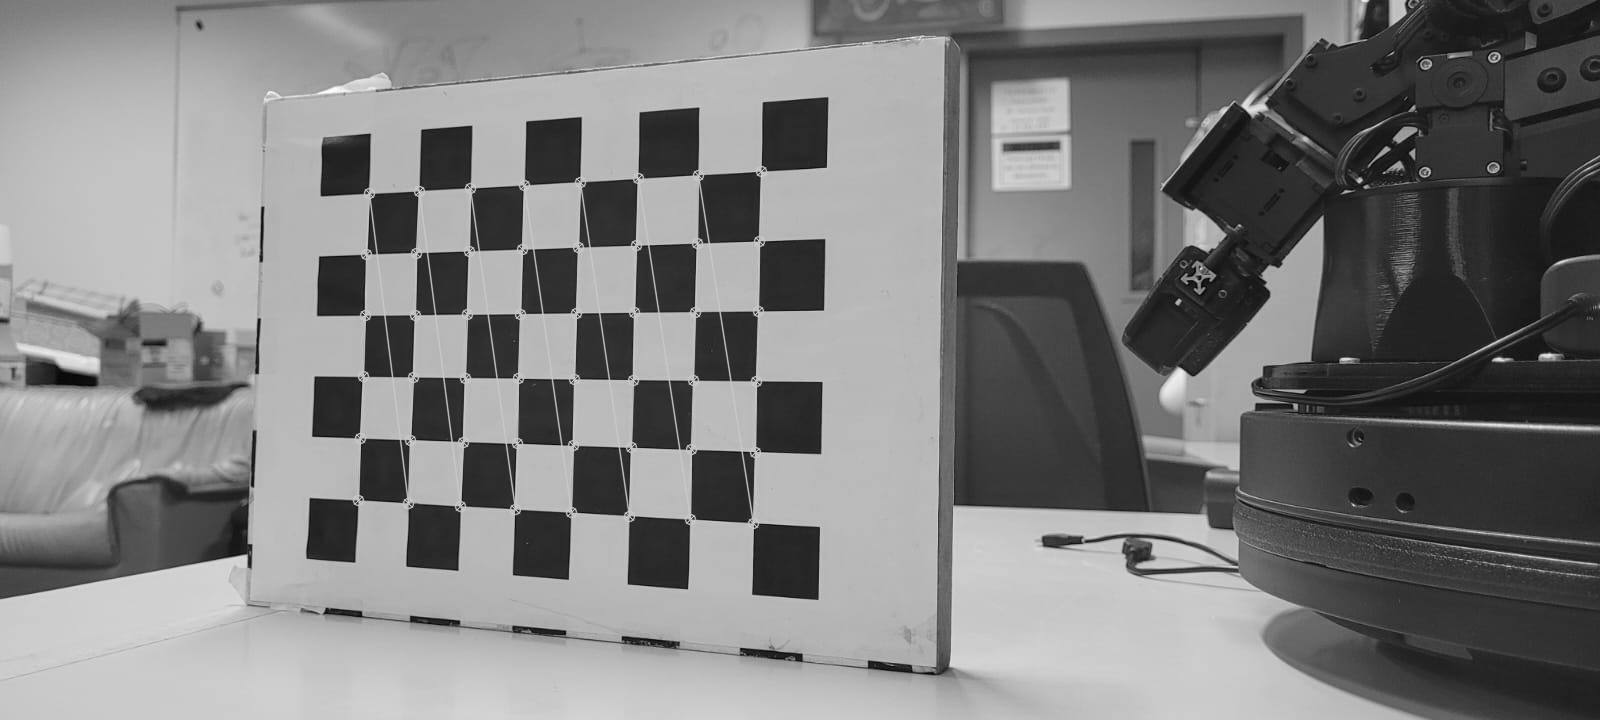

In [10]:
corner_list = []
chessboard_size = (6,8)
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30,0.001)
for i in range(1,9):
    frame = cv2.imread(f"Intro2ML_Assignments/Assignment1/Checkerboard_{i}.jpeg")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, initialcornervalues = cv2.findChessboardCorners(gray,chessboard_size,None)
    if ret:
        print(f"Image:{i} with corners detected and saved in 'Corners_List.npy'")
        corners = cv2.cornerSubPix(gray,initialcornervalues,(11,11),(-1,-1),criteria)
        corner_list.append(corners)
        cv2.drawChessboardCorners(gray,chessboard_size,corners,ret)
        cv2_imshow(gray)
        if cv2.waitKey(0)==ord('s'):
            cv2.destroyAllWindows()

np.save('Corners_List',corner_list,allow_pickle=True)

In this cell we use the corners coordinates from the above cell to find the camera calibration matrix.

In [11]:
# Define real-world object points

square_size = 2.4  # in cm, therefore the camera parameters will be in cm.
# 2.4 cm is the approximated length of the square measured by a ruler.

h,w = 480,640  # Image resolution (dependant on the camera)

# Preparing the object points:
objp = np.zeros((chessboard_size[1]*chessboard_size[0], 3), np.float32)

objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

objpoints = [objp for _ in range(len(corner_list))]  # same shape for each frame


# Calibrate the camera
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, corner_list, (w, h), None, None
)

np.save("Phone_Camera_Matrix.npy", camera_matrix)
np.set_printoptions(precision=2, suppress=True)
print("Calibration complete.\n")
print("Camera Matrix:\n", camera_matrix)

Calibration complete.

Camera Matrix:
 [[1230.55    0.    805.12]
 [   0.   1227.88  341.53]
 [   0.      0.      1.  ]]


# Analysis:
**For the Harris corner detector:**

It can be seen that the performance of the algorithm of the Harris corner detector is very good, it detects all the corners of the checkerboard whether internal corners or corners at the boundaries.

Compared to the baseline, it's as consistent as the built-in Harris detector function from the Open-CV library where the results of the two look identical.

It can be noticed that the interior corners of the checkerboard (dots in red) are thicker than the corners at the boundaries, this is the case because on a checkerboard, interior corners have two strong edges in both x and y directions, so the response spreads out more. In addition that Harris corner detector computes a score (the Harris response) at every pixel based on gradient changes in a window, where two strong, perpendicular edges meet, the response is high across a small neighborhood, not just one pixel.

**For the camera matrix:**

The camera matrix $K = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}=\begin{bmatrix} 1230.55 & 0 & 805.12 \\ 0 & 1227.88 & 341.53 \\ 0 & 0 & 1 \end{bmatrix}$

Here’s a brief explanation of each part of the camera calibration matrix:

- **Top-left (1230.55) →** \($f_x$\)  , the focal length in pixels along the x-axis (image width direction).  
- **Middle (1227.88) →** \($f_y$\), the focal length in pixels along the y-axis (image height direction).  
- **Top-right (805.12) →** \($c_x$\), the x-coordinate of the principal point (usually near the image center).  
- **Center-right (341.53) →** \($c_y$\), the y-coordinate of the principal point.



